In [27]:
import time
import torch
from utils import image_utils
from utils.image_utils import gen_index_file
from unet.dataset import SegThorImagesDataset
from torch.utils.data import DataLoader, random_split
from unet.unet_model import UNet
from unet.simplified_unet_model import SimplifiedUNet
from unet.loss import GeneralizedDiceLoss, print_dice_by_category
from torch import optim
from torch import nn
import os 
import pandas as pd 
from torchvision.transforms import v2
from importlib import reload

import pandas as pd
from sklearn.model_selection import train_test_split 

In [28]:
# if index file doesn't exist, generate and save 
filenames = image_utils.gen_index_file(root='/home/jupyter/ecs271_data/data/train')
filenames

Filename: data/train_patient_idx.csv already exists, skipping gen


In [29]:
DATA_DIR = '/home/jupyter/ecs271_data/data/train'
EXPERIMENT_DIR = '/home/jupyter/ecs271_data/experiments'
TRAIN_CSV = "data/train_patient_idx_sorted.csv"
VALID_CSV = "data/valid_patient_idx_sorted.csv"
INPUT_DATA_INDEX = 'data/train_patient_idx.csv'
TEST_CSV = "data/test_patient_idx.csv"

In [18]:
# split the source train data into 80/20 train/valid split if needed

df = pd.read_csv(INPUT_DATA_INDEX)
def split_to_train_valid_dfs(df, filenames = [TRAIN_CSV, VALID_CSV]):
    for file in filenames:
        if os.path.isfile(file):
            print(f"File exists: {file}, skipping")
            return

    print(f"One of files does not exist, splitting")

    train_df, valid_df = train_test_split(df, test_size=0.2, random_state=42)

    # order by slice_idx for caching and speed up of DataLoader
    sorted_train = train_df.sort_index()
    sorted_valid = valid_df.sort_index()
    sorted_train.to_csv(train_csv, index=False)
    sorted_valid.to_csv(valid_csv, index=False)
    
split_to_train_valid_dfs(df, [train_csv, valid_csv])



File exists: data/train_patient_idx_sorted.csv, skipping


In [19]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("GPU is available. ")
else:
    device = torch.device("cpu")
    print("GPU is not available, using CPU instead.")

GPU is available. 


In [23]:
# define model
# define training loop

def create_experiment_dir(experiment_name, experiment_dir: str = EXPERIMENT_DIR):
    # Check if the directory exists and create it if it doesn't
    if experiment_name not in os.listdir(experiment_dir):
        os.makedirs(os.path.join(experiment_dir, experiment_name))
        print(f"Directory {experiment_name} created.")
    else:
        print(f"Directory {experiment_name} already exists.")    
        
        
def train_model(experiment_name: str, # for logging state dict and checkpointing
                experiment_dir: str = EXPERIMENT_DIR,
                train_csv = TRAIN_CSV,
                valid_csv = VALID_CSV,
                data_dir: str = DATA_DIR,
                epochs=10,
                dropout=0.2,
                lr=0.0001,
               batch_size=16,
               use_cache=True):
    
    create_experiment_dir(experiment_name, experiment_dir)
    experiment_path = f"{experiment_dir}/{experiment_name}"


    
    train_dataset = SegThorImagesDataset(
        patient_idx_file=train_csv,
        root_dir=data_dir,
        img_crop_size=312, 
        mask_output_size=220,
        cache_size=1
        ) 

    valid_dataset = SegThorImagesDataset(
        patient_idx_file=valid_csv,
        root_dir=data_dir,
        img_crop_size=312, 
        mask_output_size=220,
        cache_size=1
        ) 

    print(f"Length of Train: {len(train_dataset)}")
    print(f"Length of Valid: {len(valid_dataset)}")

    shuffle = not use_cache
    
    train_dl = DataLoader(train_dataset, batch_size=batch_size, shuffle=shuffle)
    valid_dl = DataLoader(valid_dataset, batch_size=batch_size, shuffle=shuffle)
    
    model = SimplifiedUNet(n_channels=1, n_classes=5, dropout=dropout) # 0: no-classification 1: organ, 2: organ, 3: organ, 4: organ

    criterion = GeneralizedDiceLoss(classes=[0, 1, 2, 3, 4]) # from SegThor paper
    optimizer = optim.Adam(model.parameters(), lr=lr)
    model.to(device)
    epoch_train_losses = []
    epoch_val_losses = []


    # [ ] TODO: image transformations at dataloader similar to SegTHOR paper, also filtering out slices with no labels
    # [ ] TODO: final evaluation of winning model
    # [ ] TODO: display the examples
    for epoch in range(epochs):
        epoch_start_time = time.time()
        model.train()
        running_loss = 0.0
        oar_dice_valid = []
        idx_time = epoch_start_time
        for idx, sample in enumerate(train_dl):
            start_time = time.time()
            inputs, targets = sample
            inputs = inputs.to(device)
            targets = targets.to(device)
            output = model(inputs)
            loss = criterion(output, targets.long())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running_loss += loss.item() 
            # if idx % 10 == 0:
            #     print(f'Train: {idx}/{len(train_dl)}: {time.time() - idx_time}: Load Time: {start_time - idx_time} : Model Time : {time.time() - start_time}')
            idx_time = time.time()
        train_loss = running_loss / len(train_dl.dataset)
        epoch_train_losses.append(train_loss)

        model.eval()
        running_val_loss = 0.0
        with torch.no_grad():
            for idx, sample in enumerate(valid_dl):
                start_time = time.time()
                inputs, targets = sample
                inputs=inputs.to(device)
                targets=targets.to(device)
                output = model(inputs)
                val_loss = criterion(output, targets.long())
                running_val_loss += val_loss.item()
                # per channel DICE avg
                predicted_cats = model.predict_class_channels(inputs)
                per_channel_dice = criterion.dice_per_channel(predicted_cats, targets.long())
                per_channel_dice.to('cpu')
                oar_dice_valid.append(per_channel_dice)
                # if idx % 10 == 0:
                #     print(f'Validation: {idx}/{len(valid_dl)}: {time.time() - start_time}')
        validation_loss = running_val_loss / len(valid_dl.dataset)

        oar_dice = torch.cat(oar_dice_valid, dim=0)
        oar_dice_mean = oar_dice.mean(dim=0)
        
        epoch_val_losses.append(validation_loss)
        
        print(f'Epoch {epoch + 1} | Duration: {time.time()- epoch_start_time} | Train Loss: {train_loss} | Validation Loss: {validation_loss}')
        print_dice_by_category(oar_dice_mean)
        
        # checkpoint the model at each epoch 
        checkpoint_path = f"{experiment_path}/checkpoint_epoch_{epoch}.pth"
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss': train_loss,
            'validation_loss': validation_loss,
            'valid_oar_dice': oar_dice_mean
        }, checkpoint_path)
        

    return model, epoch_val_losses, epoch_train_losses

In [24]:
experiment_name = 'simplified_unet_08_limited_train'

In [25]:
model, val_losses, train_losses = train_model(experiment_name = experiment_name, epochs=40, batch_size=16, dropout=0.2)

Directory simplified_unet_08_limited_train already exists.
Length of Train: 4420
Length of Valid: 1105
Epoch 1 | Duration: 230.1147484779358 | Train Loss: 0.9053798121564528 | Validation Loss: 0.9007069659988265
background: 0.7100, esophagus: 0.4761, heart: 0.1223, trachea: 0.6300, aorta: 0.3553
Epoch 2 | Duration: 230.06671166419983 | Train Loss: 0.8915449634396653 | Validation Loss: 0.8916474016543428
background: 0.7250, esophagus: 0.4825, heart: 0.1247, trachea: 0.7186, aorta: 0.1388
Epoch 3 | Duration: 229.98295855522156 | Train Loss: 0.8825175439070793 | Validation Loss: 0.8854305210156678
background: 0.8075, esophagus: 0.4825, heart: 0.1368, trachea: 0.7205, aorta: 0.1970
Epoch 4 | Duration: 230.2059361934662 | Train Loss: 0.8764534584537351 | Validation Loss: 0.8807577080316673
background: 0.8953, esophagus: 0.4825, heart: 0.1289, trachea: 0.7205, aorta: 0.3070
Epoch 5 | Duration: 229.7604010105133 | Train Loss: 0.8728797432524047 | Validation Loss: 0.8786244768362779
background

ValueError: If using all scalar values, you must pass an index

In [ ]:
# finally log the final state and validation/train losses in a csv for easier lookups
experiment_path = f"{EXPERIMENT_DIR}/{experiment_name}"
df = pd.DataFrame({
    "validation_loss": val_losses,
    "train_loss": train_losses
}, )
df.to_csv(f"{experiment_path}/epoch_data.csv", index=False)

In [47]:
from utils import image_utils
train_dataset = SegThorImagesDataset(
    patient_idx_file=train_csv,
    root_dir=DATA_DIR,
    img_crop_size=312, 
    mask_output_size=220,
    cache_size=1
    )

train_dl = DataLoader(train_dataset, batch_size=1)

X, Y = train_dataset[1100]

In [ ]:
# Baseline Exp
model1 = SimplifiedUNet(n_channels=1, n_classes=5, dropout=0.2)

Supervised Loss = Dice Loss


# Experiment 1
subnet1 = SimplifiedUNet(n_channels=1, n_classes=5, dropout=0.2)
subnet2 = SimplifiedUNet(n_channels=1, n_classes=5, dropout=0.2)

# compare subnet1 and subnet2
Supervised Loss = Dice Loss + Rectification Loss

# Experiment 2 - maybe
subnet1 = pretrained UNet
subnet2 = pretrained ResNet

Supervised Loss = Dice Loss + Rectification Loss

# Experiment 3
subnet1 = pretrained UNet
subnet2 = pretrained ResNet

Supervised Loss = Dice Loss + Rectification Loss
Unsupervised Loss = Consistency weight*Consistency Loss

Loss = Supervised Loss + Unsupervised Loss


In [26]:
from utils.model_utils import get_model_from_checkpoint

model_epoch = SimplifiedUNet(n_channels=1, n_classes=5, dropout=0.2) # 0: no-classification 1: organ, 2: organ, 3: organ, 4: organ
model_epoch = get_model_from_checkpoint(experiment_dir = EXPERIMENT_DIR, 
                                        experiment_name = experiment_name, 
                                        model=model_epoch, epoch=39)
plot_XY_for_preds(model_epoch, X, Y)

NameError: name 'plot_XY_for_preds' is not defined

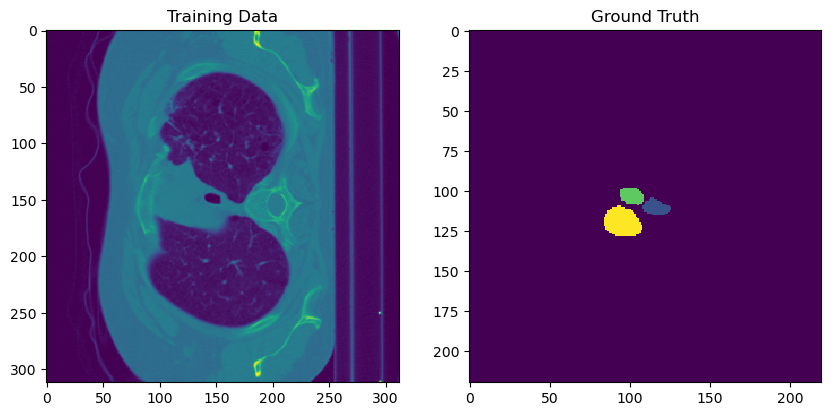

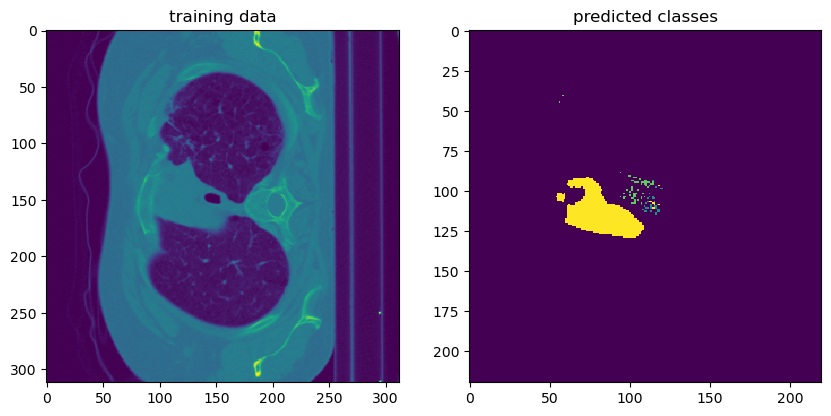

In [49]:
image_utils.plot_XY_pred_class(model_epoch, X, Y)